## Result Visualization ##

In this part of the project we will visualize concrete examples from action values given by our model and evaluate the capabilities and limitations of our model.

First we load the data from the previous step. If you have not already you should run the file 2_Training_Model.ipynb to retrieve the data and save it to a file.

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
import numpy as np
from matplotlib.patches import Circle, FancyArrowPatch, Rectangle, RegularPolygon
from matplotlib.patheffects import withStroke

df_model = pd.read_pickle("data_cleaned_trained.pkl")

Once the data is loading we can start with the visualization, we use this function to plot game states and action sequences.

Team: Argentina


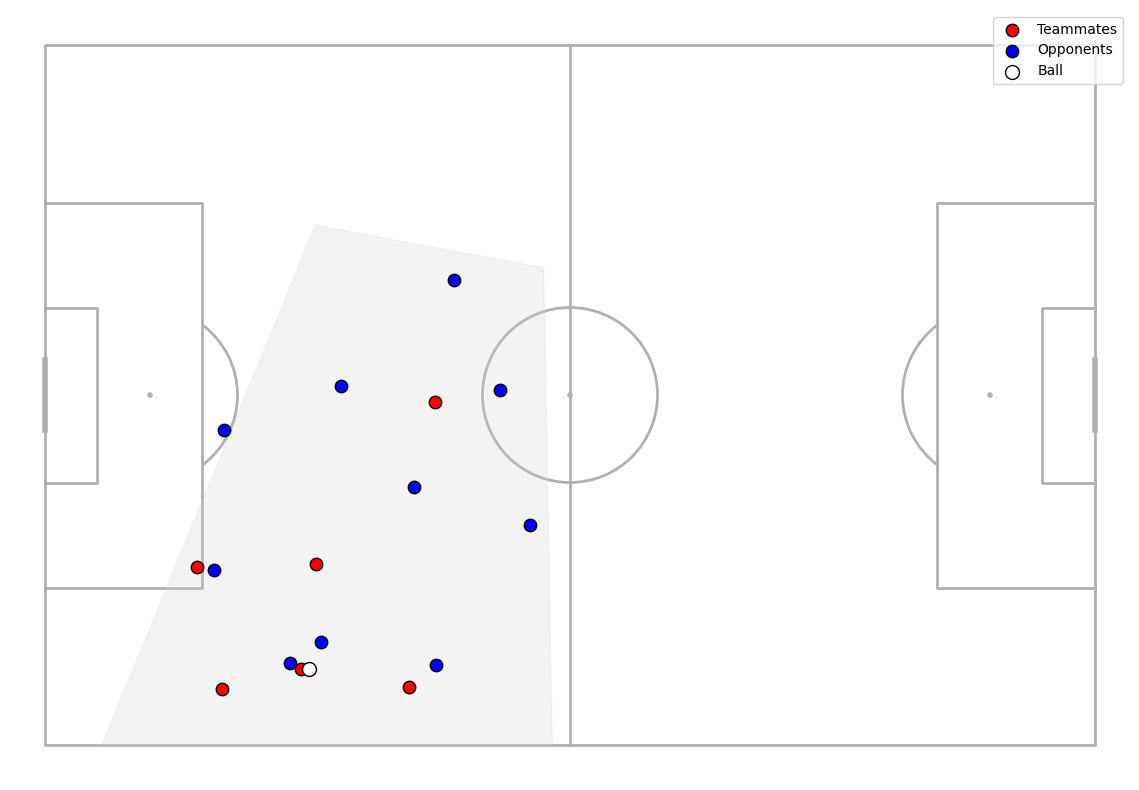

In [34]:
def plot_event_with_360(event_row, show_event_location=True):
    p = Pitch(pitch_type='statsbomb')
    fig, ax = p.draw(figsize=(12, 8))

    if isinstance(event_row['visible_area'], list) and len(event_row['visible_area']) >= 2:
        visible_area = np.array(event_row['visible_area']).reshape(-1, 2)
        p.polygon([visible_area], color='lightgray', alpha=0.25, ax=ax)

        if isinstance(event_row['freeze_frame'], list) and len(event_row['freeze_frame']) > 0:
            freeze_frame_df = pd.DataFrame(event_row['freeze_frame'])

            teammate_locs = freeze_frame_df[freeze_frame_df['teammate']]
            opponent_locs = freeze_frame_df[~freeze_frame_df['teammate']]

            p.scatter(teammate_locs['x'], teammate_locs['y'],
                      c='red', s=80, ec='k', ax=ax, label='Teammates')
            p.scatter(opponent_locs['x'], opponent_locs['y'],
                      c='blue', s=80, ec='k', ax=ax, label='Opponents')
    else:
        print("No visible_area available; only plotting event location.")

    if show_event_location and ('x' in event_row and 'y' in event_row):
        if pd.notna(event_row['x']) and pd.notna(event_row['y']):
            p.scatter(event_row['x'] + 1, event_row['y'],
                      c='white', s=100, ax=ax, ec='k', label='Ball')

            label_text = event_row.get('type_name', 'Event')
            if pd.notna(event_row.get('sub_type_name')):
                label_text += f" ({event_row['sub_type_name']})"

    ax.legend()
    plt.show()

idx = 3678

event_row = df_model.iloc[idx]
print(f"Team: {event_row['team_name']}")

plot_event_with_360(event_row)

In [73]:
LOW_VALUE_ACTIONS = ['ball recovery']


def fix_coordinates(sequence, attacking_team=None):
    sequence = sequence.copy()

    if attacking_team is None:
        attacking_team = sequence.iloc[-1].get('team_name')

    for i, row in sequence.iterrows():
        team = row.get('team_name')
        if team != attacking_team:
            sequence.at[i, 'x'] = 120 - row['x'] if not pd.isna(row['x']) else row['x']
            sequence.at[i, 'y'] = 80 - row['y'] if not pd.isna(row['y']) else row['y']

    return sequence

def get_action_chain(df, event_id, window=6):
    df = df.reset_index(drop=True)
    pos = df.query("id == @event_id").index

    if len(pos) == 0:
        raise ValueError(f"Event ID '{event_id}' not found.")
    pos = pos[0]

    chain = []
    picked_indices = set()
    i = pos

    while len(chain) < window and i >= 0:
        row = df.iloc[i]
        action = str(row.get("type_name", "")).lower()

        if i in picked_indices:
            i -= 1
            continue

        if action in LOW_VALUE_ACTIONS:
            for j in range(i - 1, -1, -1):
                prev_row = df.iloc[j]
                prev_action = str(prev_row.get("type_name", "")).lower()
                if prev_action not in LOW_VALUE_ACTIONS and j not in picked_indices:
                    chain.insert(0, prev_row)
                    picked_indices.add(j)
                    break
        else:
            chain.insert(0, row)
            picked_indices.add(i)

        i -= 1

    return pd.DataFrame(chain)

In [74]:
def plot_action_chain_by_id(df, event_id):
    event_pos = df.reset_index(drop=True).query("id == @event_id").index

    if len(event_pos) == 0:
        print(f"[ERROR] Event ID '{event_id}' not found in DataFrame.")
        return

    pos = event_pos[0]
    start_pos = max(0, pos - 5)
    sequence = get_action_chain(df, event_id)
    sequence = fix_coordinates(sequence)



    if sequence.empty:
        print(f"[ERROR] No sequence found for event ID '{event_id}'")
        return

    fig, axs = plt.subplots(2, 1, figsize=(12, 10), gridspec_kw={'height_ratios': [1, 4]})
    table_ax, pitch_ax = axs
    table_ax.axis("off")

    col_labels = ['#', 'TIME', 'PLAYER', 'ACTION', r'$P_{scores}$', 'VALUE']
    cell_text = []

    for display_idx, (_, row) in enumerate(sequence.iterrows(), 1):
        time = f"{int(row.get('minute', 0))}m{int(row.get('second', 0))}s"
        player = row.get('player_name', 'Unknown')
        action = row.get('type_name', 'Action').lower()
        pscore = round(row.get('predicted_goal_prob', 0.0), 2)
        value = round(row.get('action_value', 0.0), 2)
        sign = "+" if value >= 0 else ""
        cell_text.append([display_idx, time, player, action, f"{pscore:.2f}", f"{sign}{value:.2f}"])

    table_ax.table(cellText=cell_text, colLabels=col_labels, cellLoc='center',
                   loc='upper center', colWidths=[0.05, 0.15, 0.2, 0.2, 0.15, 0.15])

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#a8bc95', line_color='white')
    pitch.draw(ax=pitch_ax)

    for i in range(len(sequence)):
        row = sequence.iloc[i]
        x, y = row.get('x'), row.get('y')
        if pd.isna(x) or pd.isna(y):
            continue

        action = str(row.get('type_name', '')).lower()
        value = round(row.get('action_value', 0.0), 2)

        if 'shot' in action:
            marker = Rectangle((x - 1, y - 1), 2, 2, color='blue', ec='k')
        elif 'dribble' in action or 'take on' in action:
            marker = RegularPolygon((x, y), numVertices=3, radius=2, orientation=np.pi / 2, color='blue', ec='k')
        else:
            marker = Circle((x, y), radius=2, color='lightblue', ec='k')

        pitch_ax.add_patch(marker)
        display_idx = i + 1
        y_offset = 4 - (display_idx % 3) * 2

        pitch_ax.text(
            x, y - y_offset,
            f"({display_idx}) {action}\n{value:+.2f}",
            fontsize=10,
            ha='center', va='top',
            color='white',
            weight='bold',
            path_effects=[withStroke(linewidth=2, foreground='black')]
        )

        if i < len(sequence) - 1:
            next_row = sequence.iloc[i + 1]
            x2, y2 = next_row.get('x'), next_row.get('y')
            if pd.isna(x2) or pd.isna(y2):
                continue

            linestyle = 'solid' if 'pass' in action or 'shot' in action else 'dashed'
            arrow = FancyArrowPatch((x, y), (x2, y2),
                                    arrowstyle='->', color='black', lw=2,
                                    linestyle=linestyle, mutation_scale=15)
            pitch_ax.add_patch(arrow)

    plt.tight_layout()
    plt.show()


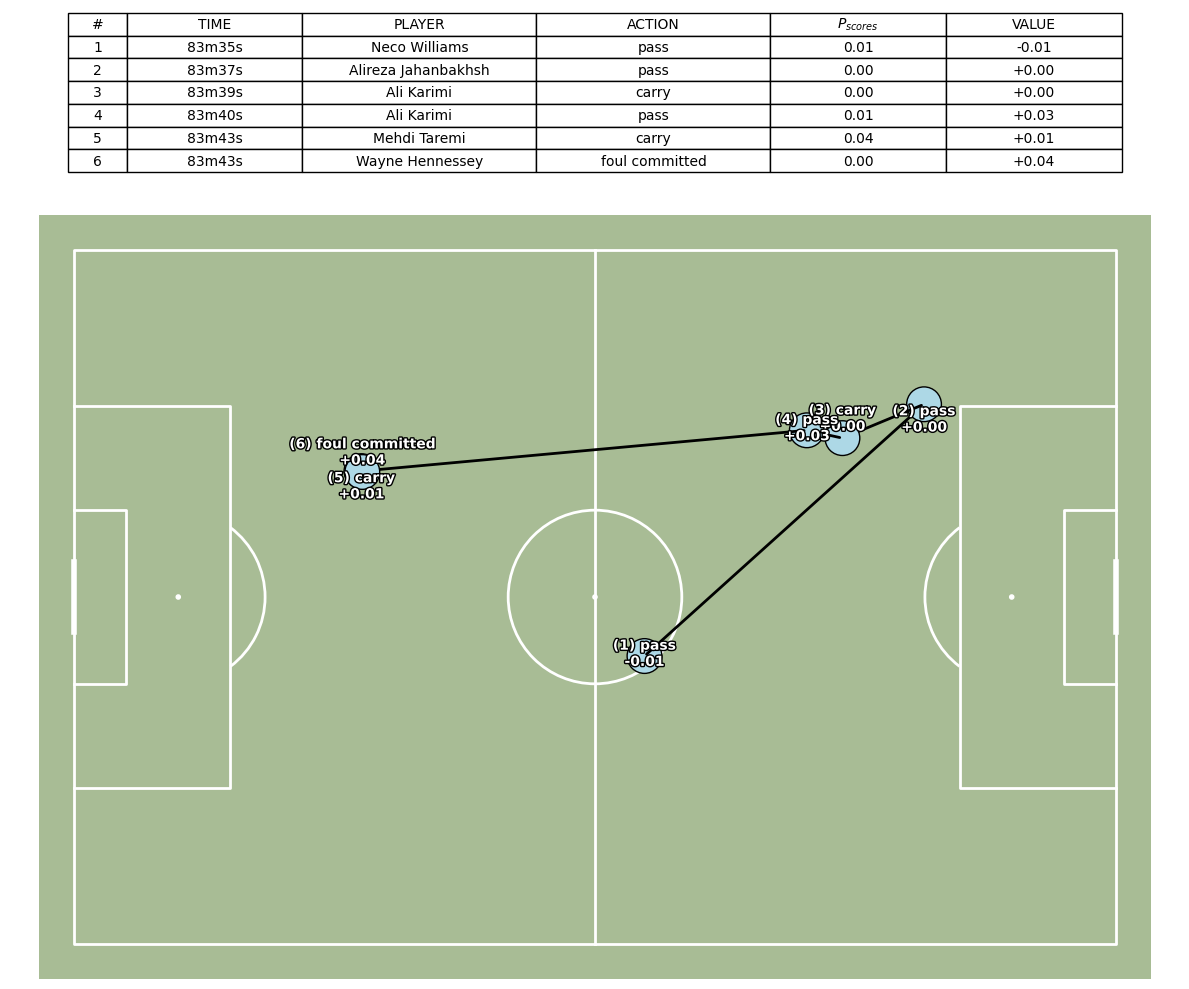

In [ ]:
plot_action_chain_by_id(df_model, "17949ad2-d653-49cb-95e4-2efe585438dc")
